# 목차

- EDA(Explatory Data Analysis) - 데이터 살펴보기
- Auto-Sklearn 사용해보기
- 성능평가

---

In [1]:
import numpy as np
import pandas as pd

# 1. EDA - 데이터 살펴보기

Kaggle의 유방암 데이터셋을 활용해 해당 데이터가 양성인지 악성인지 구분하는 calssification 문제를 해결하고자 합니다. 데이터의 출처는 다음 [링크](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)와 입니다.

In [2]:
data = pd.read_csv('data.csv')

### 1) 컬럼, 결측값 확인
먼저 데이터에 존재하는 컬럼(변수)과 결측값을 확인해보겠습니다.

- diagnosis : 진단결과 (B 양성, M: 악성)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### 2) 불필요한 컬럼 삭제

In [5]:
data = data.drop(columns=['Unnamed: 32'])

### 3) 데이터셋 분포 확인

In [6]:
data.diagnosis.value_counts(normalize=True)

diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64

### (*) train / test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data[[col for col in data.columns if col not in ['id','diagnosis']]],
                                                    data['diagnosis'], test_size = 0.33)

# 2. auto-sklearn 사용해보기
- autosklearn은 AutoML을 위한 오픈소스 라이브러리입니다.
- 해결하고자 하는 문제에 따라 AutoSklearnClassifier 또는 AutoSklearnRegressor 를 사용할 수 있습니다.

## 1) auto-sklearn 설치하기

In [9]:
# pip install auto-sklearn
# pip install scikit-learn==1.0.2

In [11]:
import autosklearn.classification

다음의 코드를 통해 함수의 설명을 확인할 수 있습니다. 이 코드에서 확인하려고하는 함수는 `autosklearn.classification.AutoSKlearnClassifier` 입니다.

In [12]:
help(autosklearn.classification.AutoSklearnClassifier)

Help on class AutoSklearnClassifier in module autosklearn.estimators:

class AutoSklearnClassifier(AutoSklearnEstimator, sklearn.base.ClassifierMixin)
 |  AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=None, initial_configurations_via_metalearning=25, ensemble_size: 'int | None' = None, ensemble_class: "Type[AbstractEnsemble] | Literal['default'] | None" = 'default', ensemble_kwargs: 'Dict[str, Any] | None' = None, ensemble_nbest=50, max_models_on_disc=50, seed=1, memory_limit=3072, include: 'Optional[Dict[str, List[str]]]' = None, exclude: 'Optional[Dict[str, List[str]]]' = None, resampling_strategy='holdout', resampling_strategy_arguments=None, tmp_folder=None, delete_tmp_folder_after_terminate=True, n_jobs: 'Optional[int]' = None, dask_client: 'Optional[dask.distributed.Client]' = None, disable_evaluator_output=False, get_smac_object_callback=None, smac_scenario_args=None, logging_config=None, metadata_directory=None, metric: 'Scorer | Sequence[Scorer] | None

## 2) auto-sklearn 으로 classification model 생성하기

### 파라미터
`autosklearn.classification.AutoSklearnClassifier`에서 사용할 수 있는 변수는 다음과 같습니다.

- time_left_for_this_task=3600 : 시간제한
- per_run_time_limit=None : ml모델 하나당 시간 제한
- max_models_on_disc=50 : 디스크에 올라갈 수 있는 maximun model 개수
- memory_limit=3072 : 단위는 MB, 해당 메모리 리밋을 넘으면 학습 중단 (멀티프로세싱하는 경우 job 하나당 사용할 메모리)
- resampling_strategy='holdout' : 오버피팅 방지를 위해 샘플링 방법 선택
- resampling_strategy_arguments=None :  오버피팅 방지를 위해 샘플링 방법 선택에 따른 값을 입력
- tmp_folder=None : configuration output과 log를 저장할 경로
- delete_tmp_folder_after_terminate=True : train 끝나고 tmp_folder 삭제할건지 선택
- n_jobs: Union[int, NoneType] = None : 병렬로 실행할 경우, job 개수, -1이면 전체 processor 사용
- load_models: bool = True : 학습 후 모델을 load할 것인지 선택

### 모델학습

In [13]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 30, tmp_folder = "./log/", memory_limit=None) # 5분 탐색을 하도록 해보자
automl

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=None, time_left_for_this_task=30,
                      tmp_folder='./log/')

In [14]:
%%time
automl.fit(x_train, y_train)

CPU times: user 1.71 s, sys: 341 ms, total: 2.05 s
Wall time: 50 s


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=None, per_run_time_limit=3,
                      time_left_for_this_task=30, tmp_folder='./log/')

## 3) auto-sklearn가 찾은 모델, cost 확인

In [15]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
3,1,0.12,mlp,0.023810,0.983557
11,2,0.06,mlp,0.031746,1.335106
13,3,0.06,mlp,0.031746,0.990387
9,4,0.06,gradient_boosting,0.039683,0.997778
2,5,0.12,random_forest,0.047619,1.273309
4,6,0.14,random_forest,0.047619,1.562674
5,7,0.12,extra_trees,0.047619,1.456393
6,8,0.06,mlp,0.047619,1.099217
7,9,0.06,random_forest,0.047619,1.575003


In [20]:
# # Ensemble -> 1개의 데이터를 예측하는데, N개의 모델을 활용하겠다 (5개의 모델로 예측해서, 5개의 예측값을 생성하고, 거기서 과반수투표/어떻게 1개의 정답값으로 만들겠다)
# [5, 1, 2, 3] -> Model 1 -> [0.9, 0.05, 0.05] -> 0
# [5, 1, 2, 3] -> Model 2 -> [0.9, 0.05, 0.05] -> 0
# [5, 1, 2, 3] -> Model 3 -> [0.05, 0.9, 0.05] -> 1
# [5, 1, 2, 3] -> Model 4 -> [0.9, 0.05, 0.05] -> 0
# [5, 1, 2, 3] -> Model 5 -> [0.05, 0.9, 0.05] -> 1

# -> array([0.108, 0.006, 0.006]) + array([0.054, 0.003, 0.003]) + array([0.054, 0.003, 0.003]) + array([0.054, 0.003, 0.003]) + array([0.054, 0.003, 0.003])

SyntaxError: invalid syntax (1513450686.py, line 1)

최적화를 위해 탐색한 범위를 간단히 확인하면 다음과 같습니다.

In [16]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: ecb498a2-c031-11ee-87e3-9f5b7cc557a7
  Metric: accuracy
  Best validation score: 0.976190
  Number of target algorithm runs: 12
  Number of successful target algorithm runs: 12
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



사용된 모델과 모델별 가중치입니다.

In [17]:
print(len(automl.get_models_with_weights()))
for info in automl.get_models_with_weights():
    print("\n")
    print("model, weight : {}\n{}".format(info[0], "-" * 10 + "\n" + str(info[1])))

12


model, weight : 0.14
----------
SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.4775492074518431, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 2, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False',

# 3. 성능평가

생성된 모델의 성능을 평가하기 위해 `정확도`, `AUC`, `Precision`, `Recall`을 산출해보았습니다.

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [70]:
model = automl

print(y_test.reset_index().groupby('diagnosis').size())
y_predict = model.predict(x_test)
y_predict_score = model.predict_proba(x_test)[:, 1]

print("Ensembled Accuracy : {}, AUC : {}, Precision : {}, Recall : {}".format(
    accuracy_score(y_test, y_predict),
    roc_auc_score(y_test, y_predict_score),
    precision_score(y_test, y_predict, pos_label='B'),
    recall_score(y_test, y_predict, pos_label='B')
))


confusion_matrix(y_test, y_predict)

diagnosis
B    124
M     64
dtype: int64
Ensembled Accuracy : 0.9521276595744681, AUC : 0.9894153225806451, Precision : 0.9389312977099237, Recall : 0.9919354838709677


array([[123,   1],
       [  8,  56]])

In [28]:
# feature importance

In [31]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_automl_class',
 '_get_param_names',
 '_get_tags',
 '_leaderboard_columns',
 '_more_tags',
 '_n_jobs',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_resolve_ensemble_class',
 '_validate_data',
 'allow_string_features',
 'automl_',
 'build_automl',
 'classes_',
 'cv_results_',
 'dask_client',
 'dataset_compression',
 'delete_tmp_folder_after_terminate',
 'disable_evaluator_output',
 'ensemble_class',
 'ensemble_kwargs',
 'ensemble_nbest',
 'ensemble_size',
 'exclude',
 'fANOVA_input_',
 'fit',
 'fit_ens

In [45]:
x_train.keys()

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [49]:
import matplotlib.pyplot as plt

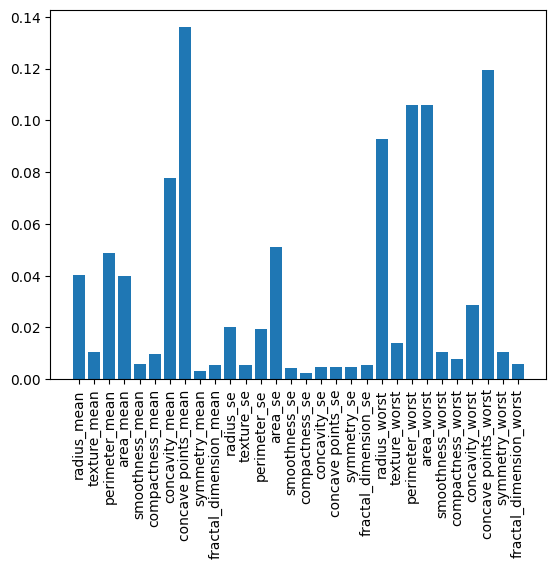

In [69]:
model_idx = 2
model.show_models()[model_idx]['sklearn_classifier'].feature_importances_

plt.bar(x=x_train.keys(), height=model.show_models()[model_idx]['sklearn_classifier'].feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [123]:
yy = []
for each in y_test.tolist():
  if yy == 'B':
    yy.append(1)
  else:
    yy.append(0)

trained_RF = automl.show_models()[model_idx]['sklearn_classifier']

model = trained_RF

print(y_test.reset_index().groupby('diagnosis').size())
y_predict = model.predict(x_test)
y_predict_score = model.predict_proba(x_test)[:, 1]

print("Ensembled Accuracy : {}, AUC : {}, Precision : {}, Recall : {}".format(
    accuracy_score(yy, y_predict),
    roc_auc_score(y_test, y_predict_score),
    precision_score(yy, y_predict),
    recall_score(yy, y_predict)
))

confusion_matrix(yy, y_predict)

diagnosis
B    124
M     64
dtype: int64
Ensembled Accuracy : 0.0, AUC : 0.8483492943548387, Precision : 0.0, Recall : 0.0


/home/jaeju/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/jaeju/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/jaeju/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0, 188],
       [  0,   0]])